# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import json
import numpy as np
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 13:27 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 13:27 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 13:27 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 13:27 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 13:27 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 13:27 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 13:27 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 13:27 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 13:27 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [6]:
ratings = sc.textFile(RATINGS_PATH) #можем так считать файл с hdfs

In [7]:
%%time
ratings.take(5) #чтобы посмотреть что находится в rdd (распределенный датасет), который прочитали. 
#take возвращает n первых строк прочитанного файла

CPU times: user 10.4 ms, sys: 2.18 ms, total: 12.6 ms
Wall time: 2.6 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions() # на сколько партиций разбились данные

5

In [9]:
#распарсим каждую строку: парсим по запятым, хотим избавиться от первой строки
ratings = ratings.map(lambda s: s.split(',')).filter(lambda arr: arr[0].isdigit()).map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

#массивы Numpy не можем хранить в rdd

In [10]:
# ratings.count()

Количество пользователей

In [11]:
%%time
#достает столбец user_id, #оставляет уникальные строки
ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 32.2 ms, sys: 6.45 ms, total: 38.6 ms
Wall time: 1min 27s


162541

Сохраним датасет в память

In [12]:
# ratings = ratings.persist()

In [13]:
# %%time

# ratings \
#     .map(lambda r: r.user_id)\
#     .distinct()\
#     .count()

Количество фильмов

In [14]:
# %%time

# ratings \
#     .map(lambda r: r.movie_id)\
#     .distinct()\
#     .count()

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [15]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [16]:
# превращает rdd в rdd, состоящий из пар; ключем будет movie_id, #для каждого фильма делаем reduce: находим все пары рейтингов и 1(пользователь 1 раз поставил рейтинг фильму)для конкретного movie_id
#первый элемент пары дает суммарный рейтинг, второй - количество рейтингов
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196631, (5.0, ['196631', 'Red Is the Color of (2007)'])),
 (131188, (5.0, ['131188', 'A Man To Remember (1938)'])),
 (148114, (5.0, ['148114', 'The Ties That Bind (2015)'])),
 (148254, (5.0, ['148254', 'A Dark Place Inside'])),
 (181175, (5.0, ['181175', 'War Requiem (1989)'])),
 (120303, (5.0, ['120303', "Girls' Club (1936)"])),
 (165285, (5.0, ['165285', 'Homeless for the Holidays (2009)'])),
 (122193, (5.0, ['122193', 'Kit Carson (1940)'])),
 (165775, (5.0, ['165775', 'Four Mothers (1941)'])),
 (182589, (5.0, ['182589', 'Witchcraft 15: Blood Rose (2017)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [17]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [18]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-17 13:30 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59139 2021-02-17 13:30 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112222 2021-02-17 13:30 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131258 2021-02-17 13:30 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114186 2021-02-17 13:30 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133841 2021-02-17 13:30 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117681 2021-02-17 13:30 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143063 2021-02-17 13:30 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132134 2021-02-17 13:30 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167794 2021-02-17 13:30 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [19]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [20]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [21]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

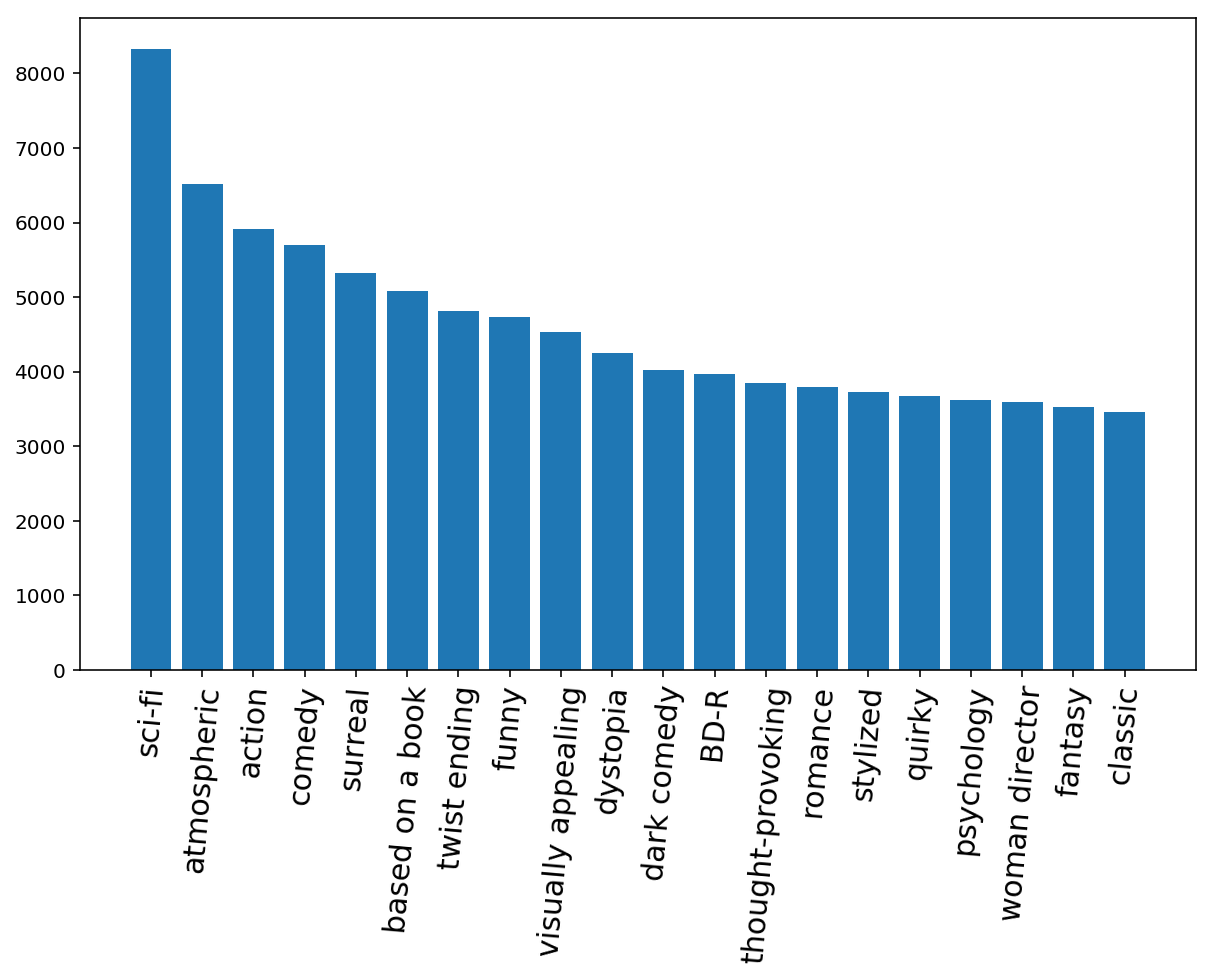

In [22]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [23]:
movies_1 = sc.textFile(MOVIES_PATH)
ratings = sc.textFile(RATINGS_PATH)

In [24]:
ratings = ratings.map(lambda s: s.split(',')).filter(lambda arr: arr[0].isdigit()).map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [25]:
movies_1 = movies_1 \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [26]:
num = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)

In [27]:
t = num \
    .join(movies_1) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)

In [28]:
t.map(lambda r: (r[1][1][1], r[1][0])).take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [29]:
num_2 = ratings \
    .filter(lambda d: d.rating == 5)\
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) 

In [30]:
t = num_2 \
    .join(movies_1) \
    .map(lambda s: (s[1][1][1], s[1][0])) \
    .sortBy(lambda key_value: key_value[1], ascending=False)

In [31]:
t.take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [32]:
movie_avg_rating.take(5)

[(32770, 3.5727272727272728),
 (5, 3.0584343520573674),
 (196615, 3.5),
 (131080, 3.0),
 (10, 3.42145763311516)]

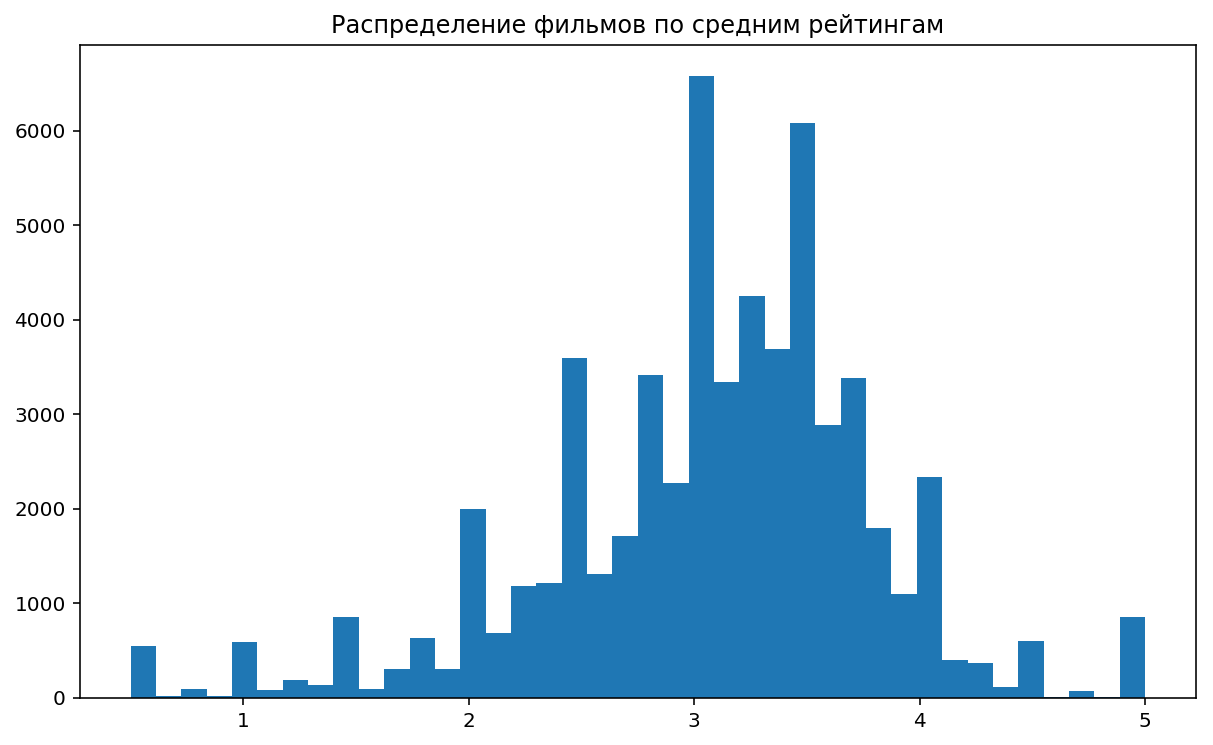

In [33]:
d_rating = movie_avg_rating \
    .map(lambda key_value: key_value[1]) \
    .collect()

f, ax = plt.subplots(figsize=(10, 6))
plt.hist(d_rating, bins=40)
plt.title('Распределение фильмов по средним рейтингам')
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [34]:
num_4 = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda t: t[1]) \
    .collect()

In [35]:
num_4[:10]

[165, 11714, 1, 97, 28265, 2760, 2, 3840, 3, 20070]

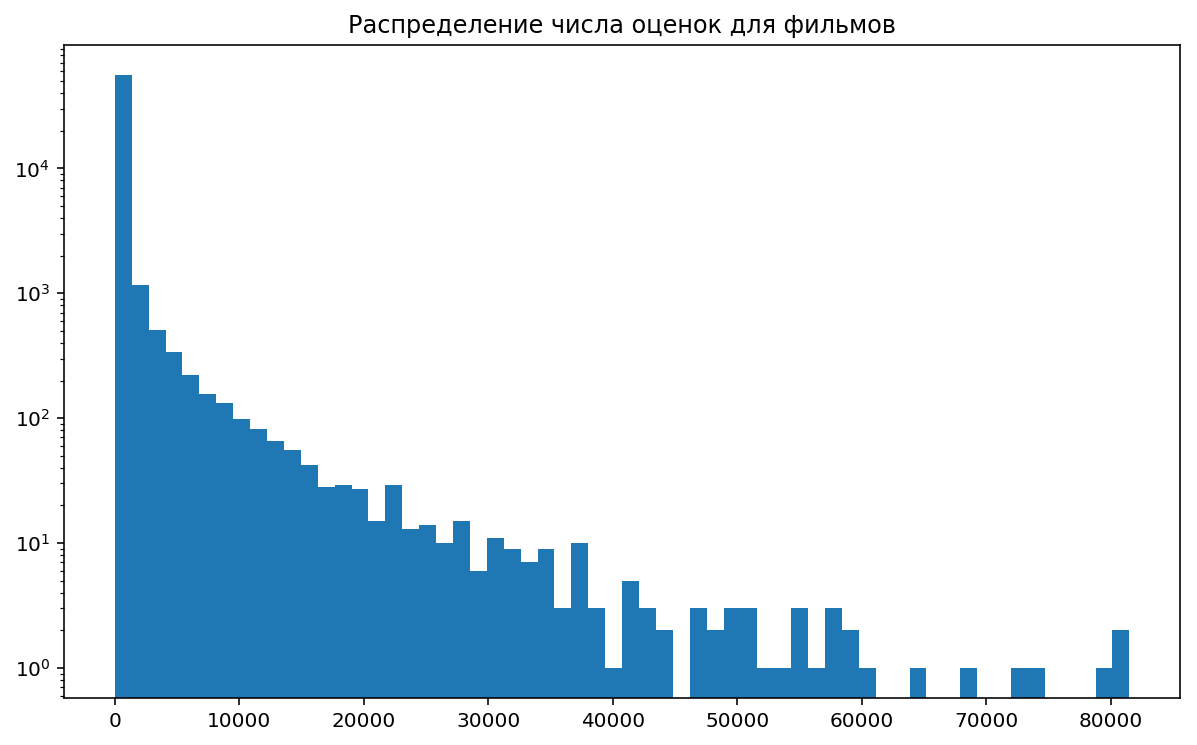

In [36]:
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(num_4, bins=60, log=True)
plt.title('Распределение числа оценок для фильмов')
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [37]:
movies = sc.textFile(MOVIES_PATH)

In [38]:
num_5 = movies \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda s: s.split(',')) \
    .flatMap(lambda s: s[-1].split('|')) \
    .map(lambda r: (r, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .collect()
    
    

In [39]:
num_5

[('Drama', 25606),
 ('Comedy', 16870),
 ('Thriller', 8654),
 ('Romance', 7719),
 ('Action', 7348),
 ('Horror', 5989),
 ('Documentary', 5605),
 ('Crime', 5319),
 ('(no genres listed)', 5062),
 ('Adventure', 4145),
 ('Sci-Fi', 3595),
 ('Children', 2935),
 ('Animation', 2929),
 ('Mystery', 2925),
 ('Fantasy', 2731),
 ('War', 1874),
 ('Western', 1399),
 ('Musical', 1054),
 ('Film-Noir', 353),
 ('IMAX', 195)]

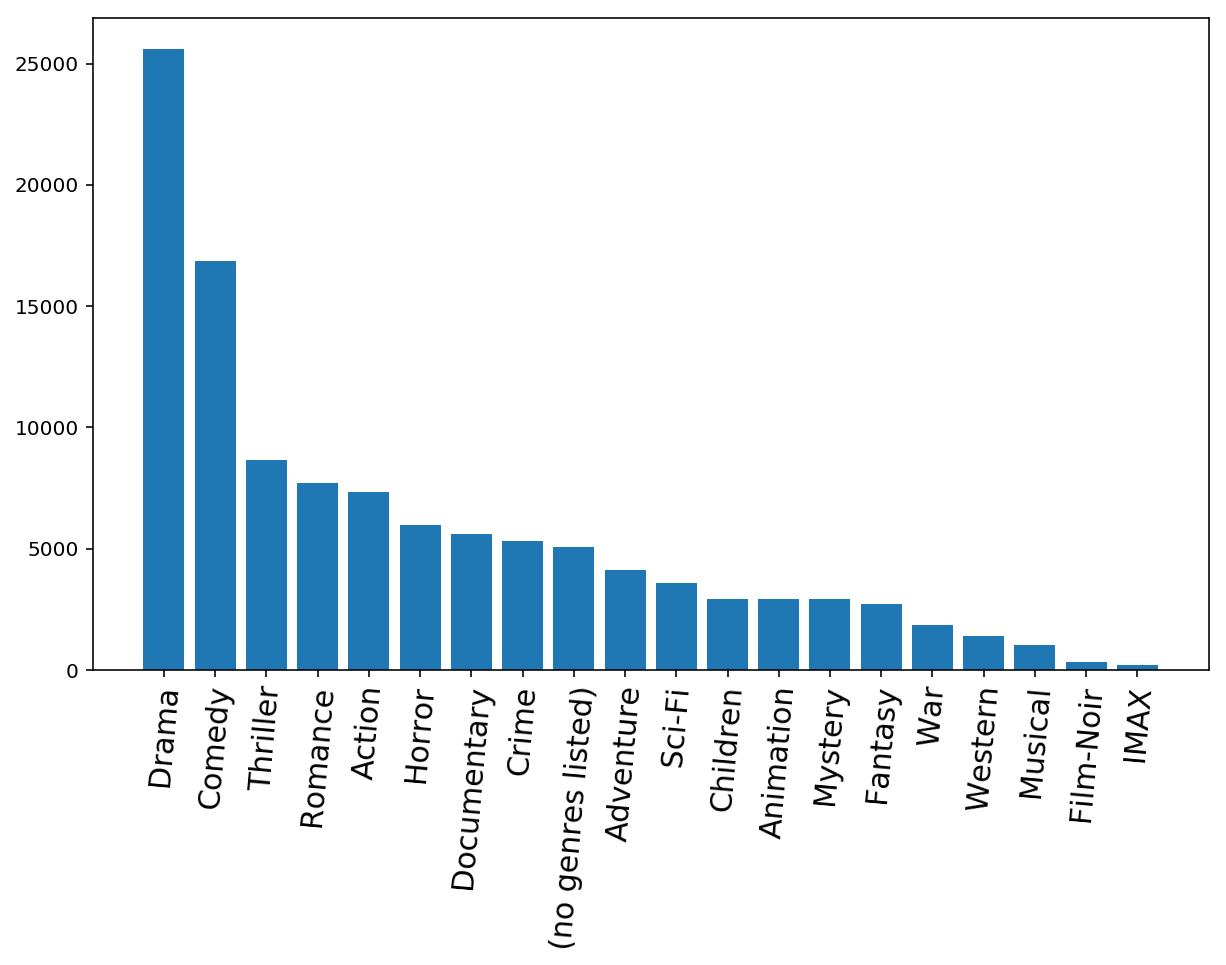

In [40]:
keys, values = zip(*num_5)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [41]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [42]:
links = sc.textFile(LINKS_PATH)
tmdb = sc.textFile(TMDB_PATH)

In [43]:
links.take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [44]:
links_1 = links \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit() and arr[1].isdigit() and arr[2].isdigit()) \
    .map(lambda arr: (int(arr[0]), int(arr[1]), int(arr[2]))) \
    .map(lambda s: (s[2], s[0]))

In [45]:
links_1.take(5)

[(862, 1), (8844, 2), (15602, 3), (31357, 4), (11862, 5)]

In [46]:
tmbd_filter = tmdb \
    .map(lambda s: json.loads(s)) \
    .filter(lambda s: "id" in s)

In [47]:
tmdb_1 = tmbd_filter \
    .map(lambda s: (s["id"], s["casts"]["cast"])) \
    .join(links_1) \
    .flatMap(lambda key_value: [(i["id"], i["name"], key_value[1][1]) for i in key_value[1][0]]) \

In [48]:
tmdb_1.take(1)

[(3129, 'Tim Roth', 18)]

In [49]:
movies = sc.textFile(MOVIES_PATH)

movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [50]:
movies_Tom = tmdb_1 \
         .keyBy(lambda s: s[2]) \
         .join(movies) \
         .map(lambda s: (s[1][0][0], s[1][0][1], s[1][1][1])) \
         .filter(lambda s: s[0] == 31 and s[1] == "Tom Hanks")\
         .map(lambda l: l[2]) \
         .collect()

In [51]:
movies_Tom

['Sleepless in Seattle (1993)',
 'Splash (1984)',
 'Every Time We Say Goodbye (1986)',
 'Elvis Has Left the Building (2004)',
 '"League of Their Own',
 '"Celluloid Closet',
 'Captain Phillips (2013)',
 'Toy Story of Terror (2013)',
 'Shooting War (2000)',
 'Killing Lincoln (2013)',
 '"\'burbs',
 'Toy Story (1995)',
 'And the Oscar Goes To... (2014)',
 'Bonfire of the Vanities (1990)',
 'Punchline (1988)',
 'Turner & Hooch (1989)',
 '"Simpsons Movie',
 'Larry Crowne (2011)',
 'Toy Story Toons: Small Fry (2011)',
 '"Man with One Red Shoe',
 'Toy Story 3 (2010)',
 'Sully (2016)',
 'Mazes and Monsters (1982)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'The Post (2017)',
 '"Money Pit',
 "You've Got Mail (1998)",
 'Toy Story 4 (2019)',
 'Radio Flyer (1992)',
 'California Typewriter (2017)',
 'Nothing in Common (1986)',
 'Angels & Demons (2009)',
 '"The Mayo Clinic',
 'Apollo 13 (1995)',
 '"Da Vinci Code',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 '"Ladykillers',


In [52]:
TOP_10 = tmdb_1 \
        .keyBy(lambda s: s[2]) \
        .join(movies).map(lambda s: ((s[1][0][0],s[1][0][1]), 1)) \
        .reduceByKey(lambda a, b: a + b)\
        .sortBy(lambda key: key[1], ascending=False)\
        .map(lambda s: (s[0][1], s[1])) \
        .take(10)

In [53]:
TOP_10

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 130)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [54]:
num_7 = tmbd_filter \
    .filter(lambda s: s["release_date"]) \
    .map(lambda s: (s["id"], int(s["release_date"][:4]))) \
    .join(links_1) \
    .map(lambda s: (s[1][1], s[1][0]))

In [55]:
num_7.take(5)

[(18, 1995), (147308, 2008), (174261, 1909), (8921, 1955), (923, 1941)]

In [56]:
num_7_2 = sc.textFile(MOVIES_PATH) \
    .map(lambda s: s.split(',')) \
    .filter(lambda s: s[0].isdigit()) \
    .map(lambda s: (s[0], s[-1])) \
    .flatMap(lambda s: [(int(s[0]),i) for i in s[1].split('|')] ) \
    .filter(lambda s: s[1] != '(no genres listed)') 

In [57]:
year_genre = num_7_2 \
    .join(num_7) \
    .map(lambda s: ((s[1][0], s[1][1]), 1)) \
    .reduceByKey(lambda a, b : a + b) \
    .map(lambda s: (s[0][1], (s[0][0], s[1]))) \
    .groupByKey() \
    .map(lambda s: (s[0], {genre : count for genre, count in s[1]})) \
    .sortByKey() \
    .collect()

In [58]:
year_genre[:10]

[(1874, {'Documentary': 1}),
 (1881, {'Documentary': 1}),
 (1888, {'Documentary': 4}),
 (1890, {'Comedy': 1}),
 (1891, {'Action': 1, 'Documentary': 4}),
 (1892, {'Animation': 1}),
 (1894, {'Comedy': 3, 'Documentary': 14, 'Drama': 1}),
 (1895, {'Comedy': 2, 'Documentary': 8, 'Drama': 1, 'Sci-Fi': 1}),
 (1896, {'Comedy': 1, 'Documentary': 8, 'Fantasy': 2, 'Horror': 3}),
 (1897,
  {'Action': 1,
   'Comedy': 2,
   'Documentary': 3,
   'Drama': 1,
   'Fantasy': 1,
   'Horror': 1,
   'War': 1})]

In [59]:
genres = num_7_2 \
    .map(lambda temp: temp[1]) \
    .distinct() \
    .sortBy(lambda x: x) \
    .collect()

In [60]:
genres

['Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [61]:
years = np.array([year for year, _ in year_genre])
years

array([1874, 1881, 1888, 1890, 1891, 1892, 1894, 1895, 1896, 1897, 1898,
       1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920,
       1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021])

In [62]:
ans = []
for _,i in year_genre:
    ratios = np.array([i[genre] if genre in i else 0 for genre in genres]) 
    ans.append(ratios / ratios.sum())
ans = np.array(ans).T   

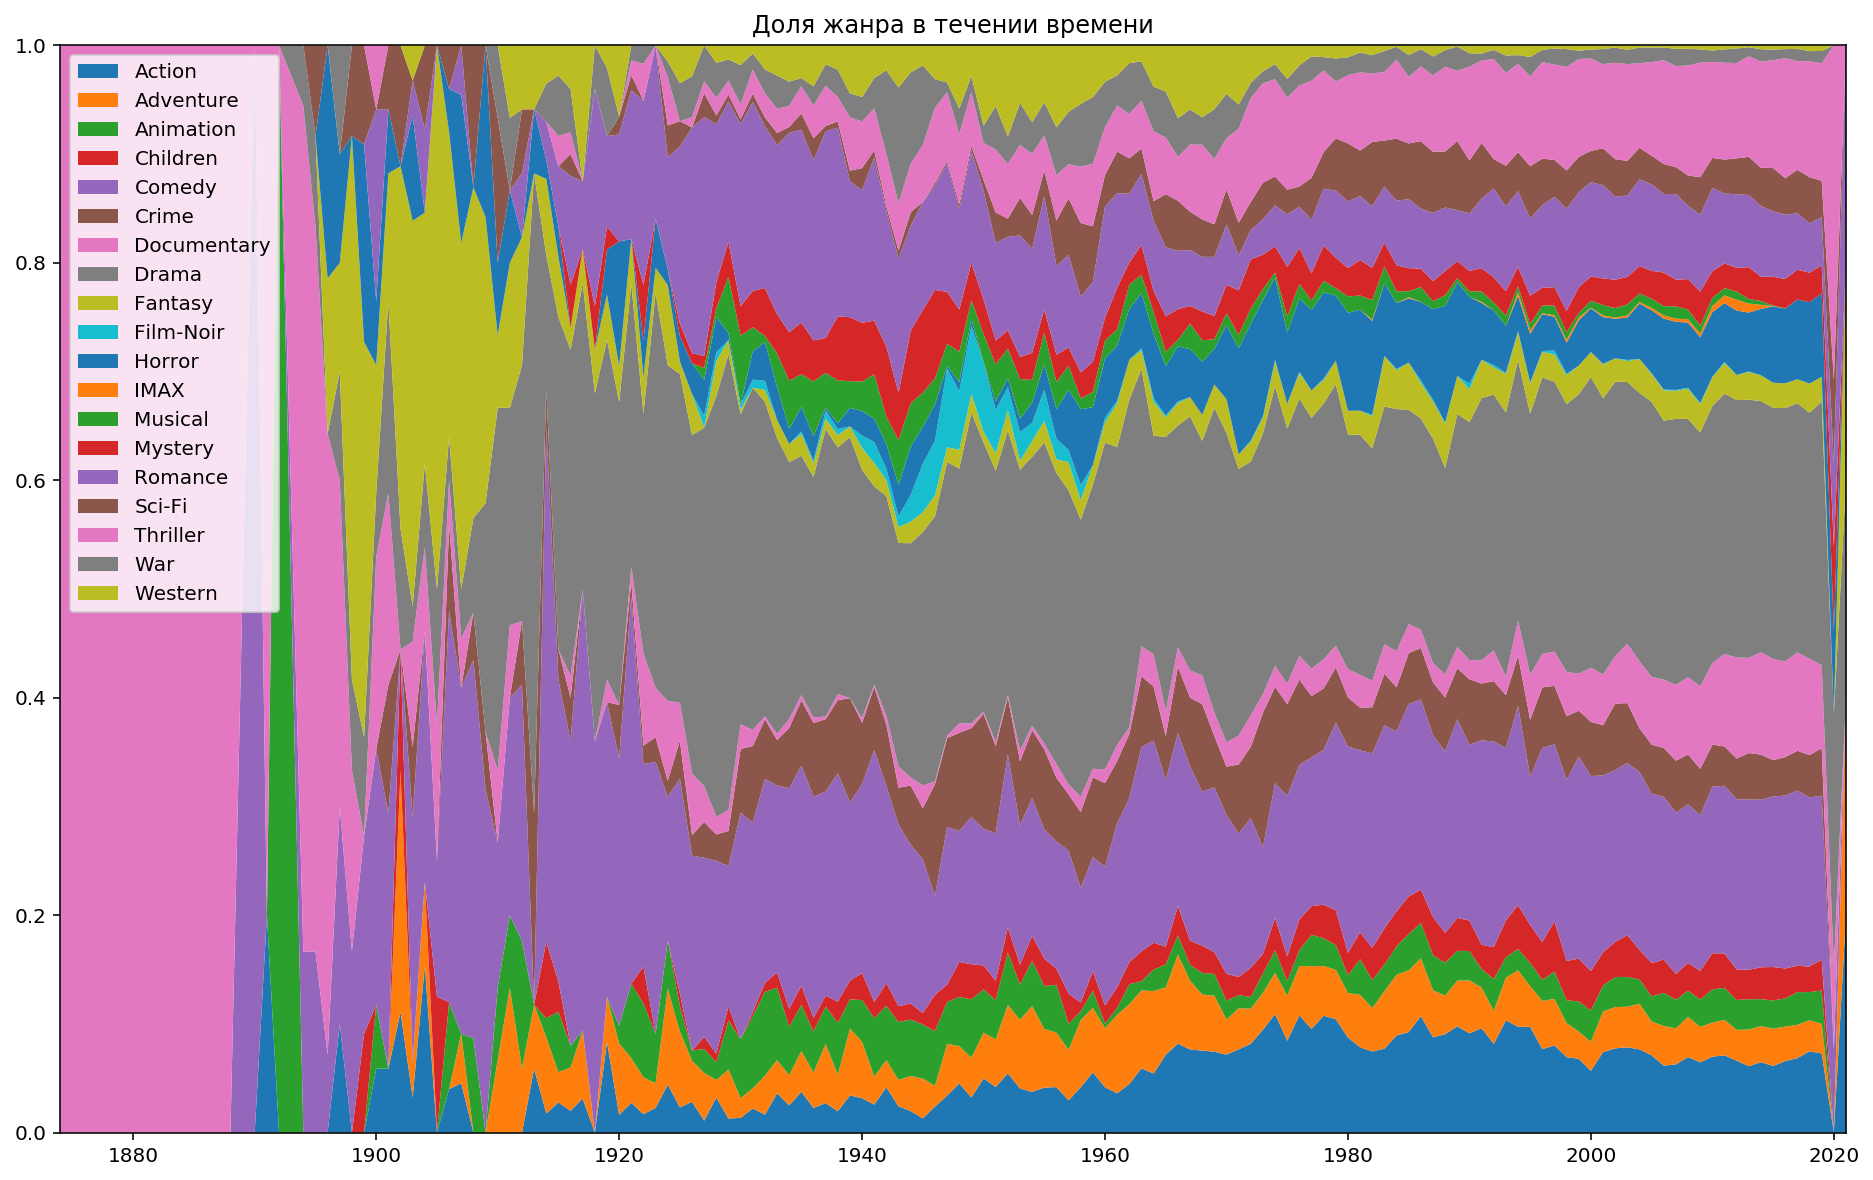

In [63]:
f, ax = plt.subplots(figsize=(16, 10))

ax.stackplot(years, ans, labels=genres)
ax.legend(loc='upper left')
plt.xlim(years[0], years[-1])
plt.ylim(0, 1)
plt.title('Доля жанра в течении времени')
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [66]:
links_1.take(5)

[(862, 1), (8844, 2), (15602, 3), (31357, 4), (11862, 5)]

In [67]:
num_8_1 = tmbd_filter \
    .map(lambda s: (s["id"], (int(s["revenue"]), int(s["budget"])))) \
    .join(links_1) \
    .map(lambda s: (s[1][1], (s[1][0][0], s[1][0][1])))

In [68]:
num_8_2 = num_7_2 \
    .join(num_8_1)\
    .map(lambda s: (s[1][0], (s[1][1][0], s[1][1][1])))\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .map(lambda s: (s[0], s[1][0] / s[1][1]))\
    .sortBy(lambda s: s[1], ascending=False)\
    .collect()

In [69]:
num_8_2

[('IMAX', 3.575514531264134),
 ('Animation', 3.53857846498367),
 ('Musical', 3.323755944655739),
 ('Adventure', 3.2072921198940243),
 ('Children', 3.090457625774435),
 ('Documentary', 3.087997822263929),
 ('Romance', 3.048998376959825),
 ('Fantasy', 3.010207886968221),
 ('Sci-Fi', 2.9920912076134987),
 ('Comedy', 2.8834000820754007),
 ('Horror', 2.8751552344153137),
 ('Action', 2.803847320893562),
 ('Mystery', 2.6455361339416426),
 ('Thriller', 2.565593492189654),
 ('Crime', 2.458730780169738),
 ('Drama', 2.4383206217360307),
 ('War', 2.0573761252451632),
 ('Film-Noir', 1.7103729583877307),
 ('Western', 1.5707315939106974)]

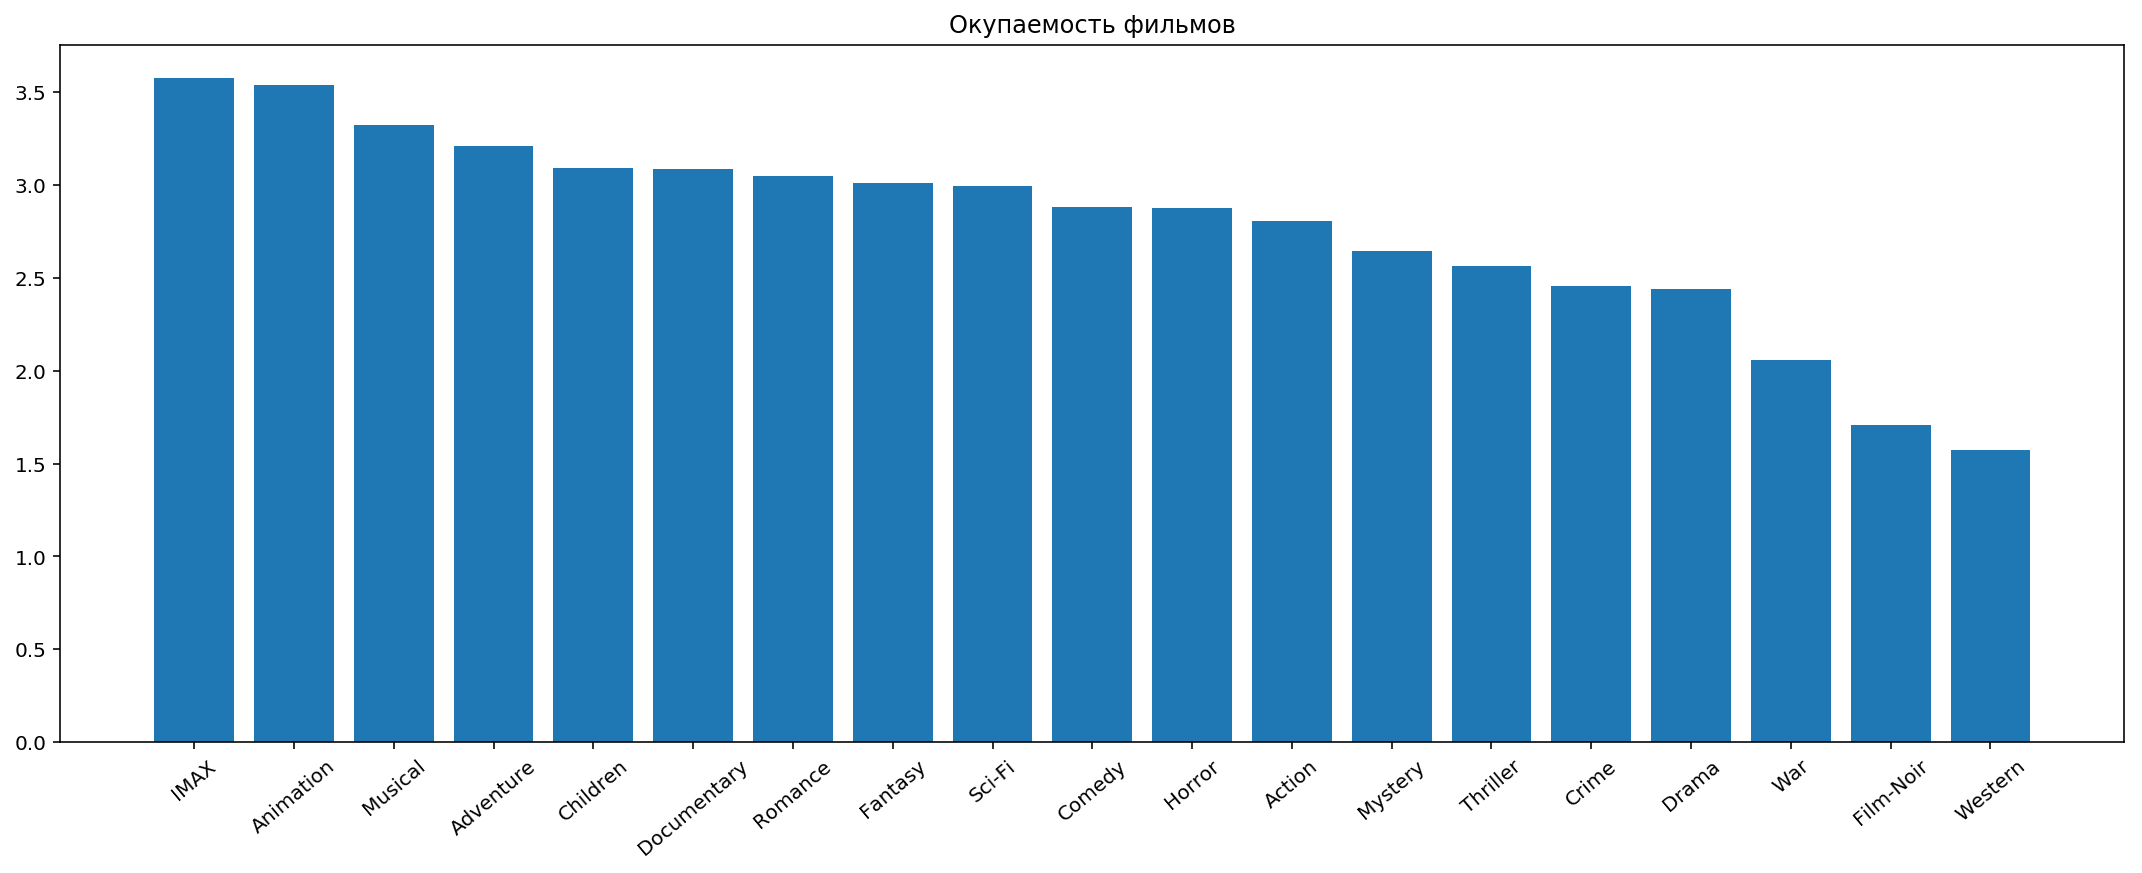

In [70]:
keys, values = zip(*num_8_2)

f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation=40, fontsize=10)
plt.bar(keys, values, align="center")
plt.tight_layout()
plt.title('Окупаемость фильмов')
plt.show()